# Skin mole classifier
### A Convolutional Deep Neural Network with Adam Optimization and User-facing UI
by Philipp Bechhaus in association with deeplearning.ai, Stanford University and the ISIC® Archive


#### Required packages:
- [numpy](www.numpy.org)
- [matplotlib](http://matplotlib.org)
- [h5py](http://www.h5py.org)
- [pillow](https://pypi.python.org/pypi/Pillow/4.2.1/)
- [scipy](https://www.scipy.org/)
- [tensorflow](https://www.tensorflow.org/)



### I. 2-layer and l-layer DNN
For comparable results

In [2]:
import os
import math
import scipy
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
from tqdm import tqdm
from random import shuffle
from dnn_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
# A. data pre-processing

TRAIN_DIR = '/Users/philipp/Projects/isic-archive-reader/images'
IMG_SIZE = 128

In [4]:
def label_img(img):
    word_label = img.split('.')[-2]
    if word_label == 'malignant':
        return 1
    elif word_label == 'benign':
        return 0

In [5]:
def label_img_cnn(img):
    word_label = img.split('.')[-2]
    if word_label == 'malignant':
        return [1,0]
    elif word_label == 'benign':
        return [0,1]

In [6]:
def create_train_data(iformat='color'):
    training_data = []
    
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        if iformat == 'color':
            label = label_img(img)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR), (IMG_SIZE, IMG_SIZE))
        elif iformat == 'grayscale':
            label = label_img_cnn(img)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    
    shuffle(training_data)
    if iformat == 'color':
        np.save('train_data.npy', training_data)
    elif iformat == 'grayscale':
        np.save('train_data_gs.npy', training_data)

    print("Training data processed!")
    return training_data

In [7]:
def create_test_data():
    testing_data = []
    
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR),(IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
     
    np.save('test_data.npy', testing_data)
    print("Testing data processed!")
    return testing_data

In [8]:
train_data = []

# if 'test_data.npy' in os.listdir(os.curdir):
#     train_data = np.load('train_data.npy')
# else:
#     train_data = create_train_data()

train_data = create_train_data()

100%|██████████| 5000/5000 [23:51<00:00,  3.07it/s]


Training data processed!


In [9]:
size_train = 1000
size_test = 100

train = train_data[0:size_train]
test = train_data[size_train+1:size_train+size_test+1]

X_train_orig = np.array([i[0] for i in train])
X_test_orig = np.array([i[0] for i in test])

Y_train_orig = [i[1] for i in train]
Y_train_orig = np.column_stack(Y_train_orig)
Y_test_orig = [i[1] for i in test]
Y_test_orig = np.column_stack(Y_test_orig)

In [10]:
# Explore dataset 
m_train = X_train_orig.shape[0]
m_test = X_test_orig.shape[0]
num_px = X_train_orig.shape[1]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("X_train_orig shape: " + str(X_train_orig.shape))
print ("Y_train_orig shape: " + str(Y_train_orig.shape))
print ("X_test_orig shape: " + str(X_test_orig.shape))
print ("Y_test_orig shape: " + str(Y_test_orig.shape))

Number of training examples: 1000
Number of testing examples: 100
Each image is of size: (128, 128, 3)
X_train_orig shape: (1000, 128, 128, 3)
Y_train_orig shape: (1, 1000)
X_test_orig shape: (100, 128, 128, 3)
Y_test_orig shape: (1, 100)


y = 0


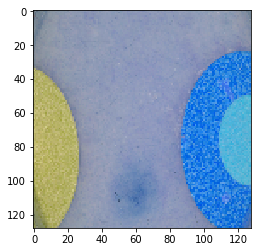

In [11]:
# Example of a picture
index = 7
plt.imshow(X_train_orig[index])
print ("y = " + str(Y_train_orig[0,index]))

In [12]:
# Reshape the training and test examples 

# The "-1" makes reshape flatten the remaining dimensions
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

print ("X_train's shape: " + str(X_train.shape))
print ("X_test's shape: " + str(X_test.shape))

X_train's shape: (49152, 1000)
X_test's shape: (49152, 100)


In [13]:
# B. 2-layer Model Definition

# num_px * num_px * 3 = 12288
n_x = 49152
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [14]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 2500, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.685105837936053
Cost after iteration 100: 0.17355437348299713
Cost after iteration 200: 0.16009367220694878
Cost after iteration 300: 0.14667868751295055
Cost after iteration 400: 0.1400017228372947
Cost after iteration 500: 0.1360285081104321
Cost after iteration 600: 0.13264248128303097
Cost after iteration 700: 0.12915845860690767
Cost after iteration 800: 0.12571411914563627
Cost after iteration 900: 0.12230566238747113
Cost after iteration 1000: 0.11879614293405556
Cost after iteration 1100: 0.11533501847091085
Cost after iteration 1200: 0.11190895646112135
Cost after iteration 1300: 0.10855867403303278
Cost after iteration 1400: 0.10525813702895893


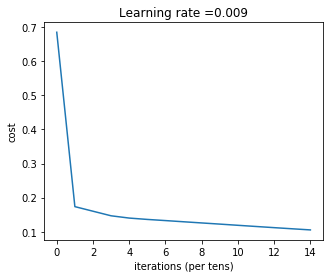

In [15]:
# C. Run 2-layer Model

parameters = two_layer_model(X_train, Y_train_orig, layers_dims = (n_x, n_h, n_y), num_iterations = 1500, print_cost=True)

In [16]:
predictions_train = predict(X_train, Y_train_orig, parameters)

Accuracy: 0.967


In [17]:
predictions_test = predict(X_test, Y_test_orig, parameters)

Accuracy: 0.95


In [18]:
# D. l-layer Model Definition

layers_dims = [49152, 20, 13, 8, 5, 1]

In [19]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.001, num_iterations = 2500, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_he(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.826992
Cost after iteration 100: 0.672014
Cost after iteration 200: 0.652657
Cost after iteration 300: 0.634256
Cost after iteration 400: 0.616751
Cost after iteration 500: 0.600080
Cost after iteration 600: 0.584223
Cost after iteration 700: 0.569116
Cost after iteration 800: 0.554661
Cost after iteration 900: 0.540866
Cost after iteration 1000: 0.527743
Cost after iteration 1100: 0.515235
Cost after iteration 1200: 0.503314
Cost after iteration 1300: 0.491928
Cost after iteration 1400: 0.481055
Cost after iteration 1500: 0.470676
Cost after iteration 1600: 0.460764
Cost after iteration 1700: 0.451255
Cost after iteration 1800: 0.442179
Cost after iteration 1900: 0.433497
Cost after iteration 2000: 0.425186
Cost after iteration 2100: 0.417227
Cost after iteration 2200: 0.409605
Cost after iteration 2300: 0.402291
Cost after iteration 2400: 0.395271


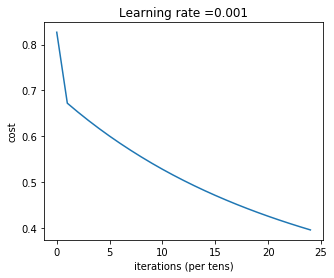

In [20]:
parameters = L_layer_model(X_train, Y_train_orig, layers_dims, num_iterations = 2500, print_cost = True)

In [21]:
pred_train = predict(X_train, Y_train_orig, parameters)

Accuracy: 0.958


In [22]:
pred_test = predict(X_test, Y_test_orig, parameters)

Accuracy: 0.97


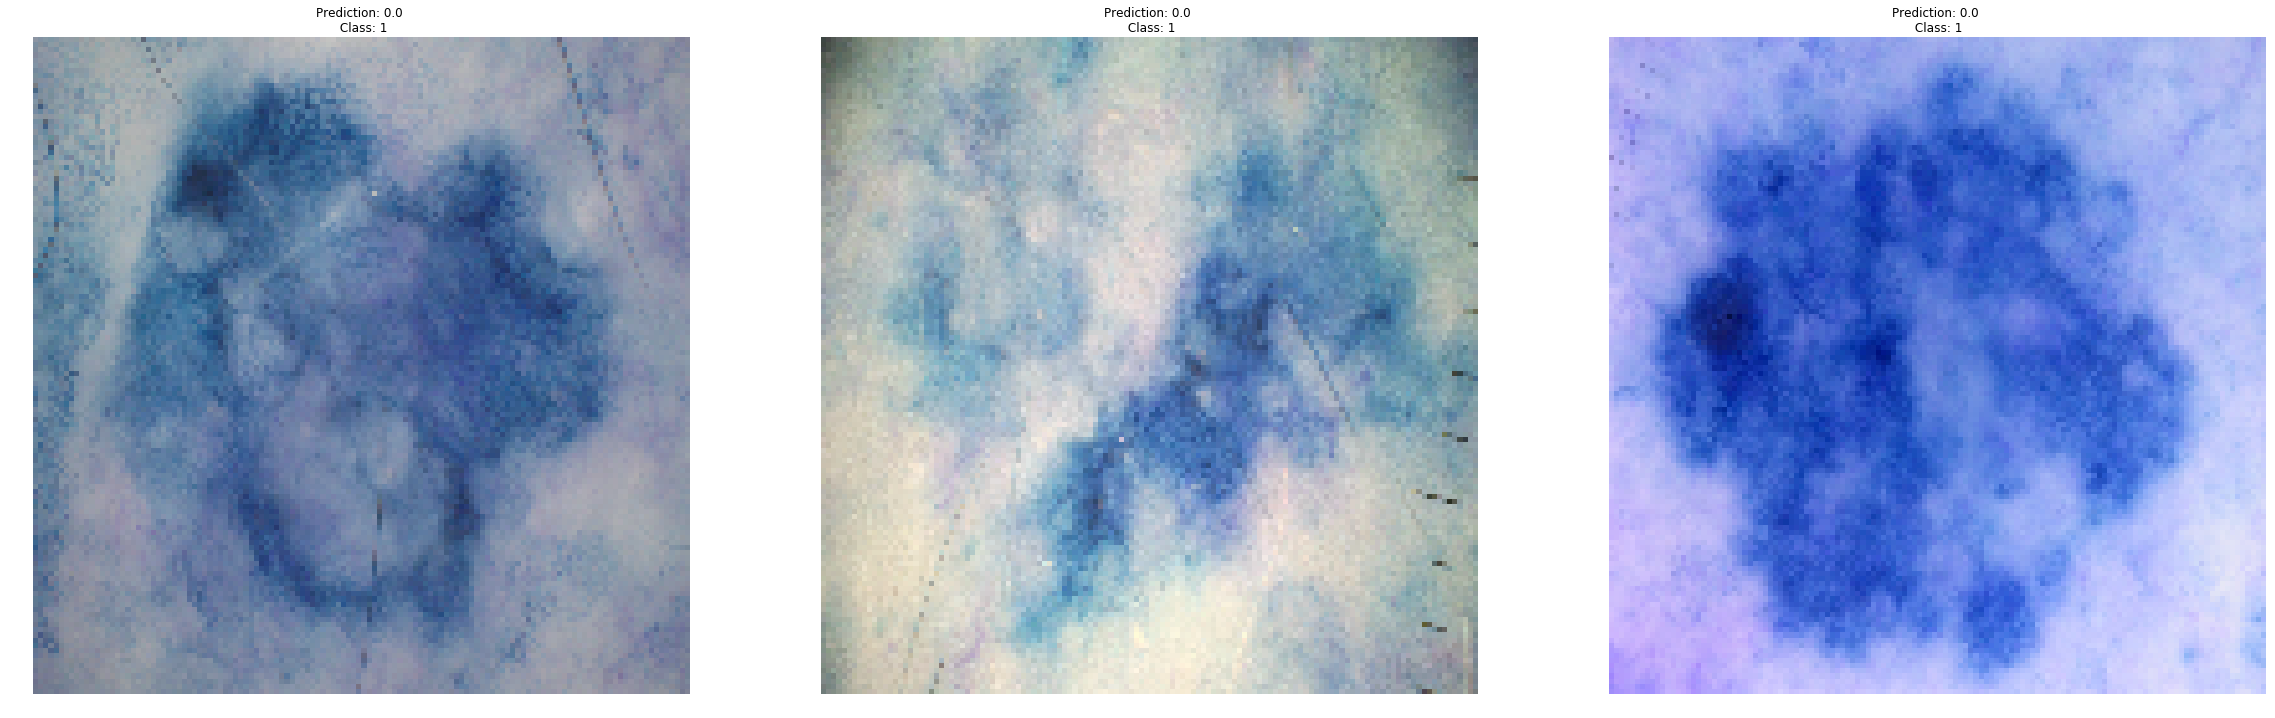

In [24]:
# E. Bad images

print_mislabeled_images_128(X_test, Y_test_orig, pred_test)

### II. Convolutional Neural Network
For higher level analysis

In [25]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

LR = 1e-3

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 4, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 4, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 4, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 4, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 4, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 4, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


In [26]:
# if 'train_data_gs.npy' in os.listdir(os.curdir):
#     train_data_gray = np.load('train_data_gs.npy')
# else:
#     train_data_gray = create_train_data(iformat='grayscale')

train_data_gray = create_train_data(iformat='grayscale')

100%|██████████| 5000/5000 [17:49<00:00,  3.69it/s]


Training data processed!


In [27]:
size_train = 4500
size_test = 500

train = train_data_gray[0:size_train]
test = train_data_gray[size_train+1:size_train+size_test+1]

In [28]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [29]:
print(X.shape)
print(test_x.shape)

(4500, 128, 128, 1)
(499, 128, 128, 1)


In [30]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
          snapshot_step=100, show_metric=True, run_id="CNN_moles_1")

Training Step: 354  | total loss: 0.09990 | time: 187.100s
| Adam | epoch: 005 | loss: 0.09990 - acc: 0.9639 -- iter: 4480/4500
Training Step: 355  | total loss: 0.09713 | time: 196.364s
| Adam | epoch: 005 | loss: 0.09713 - acc: 0.9644 | val_loss: 0.08565 - val_acc: 0.9679 -- iter: 4500/4500
--


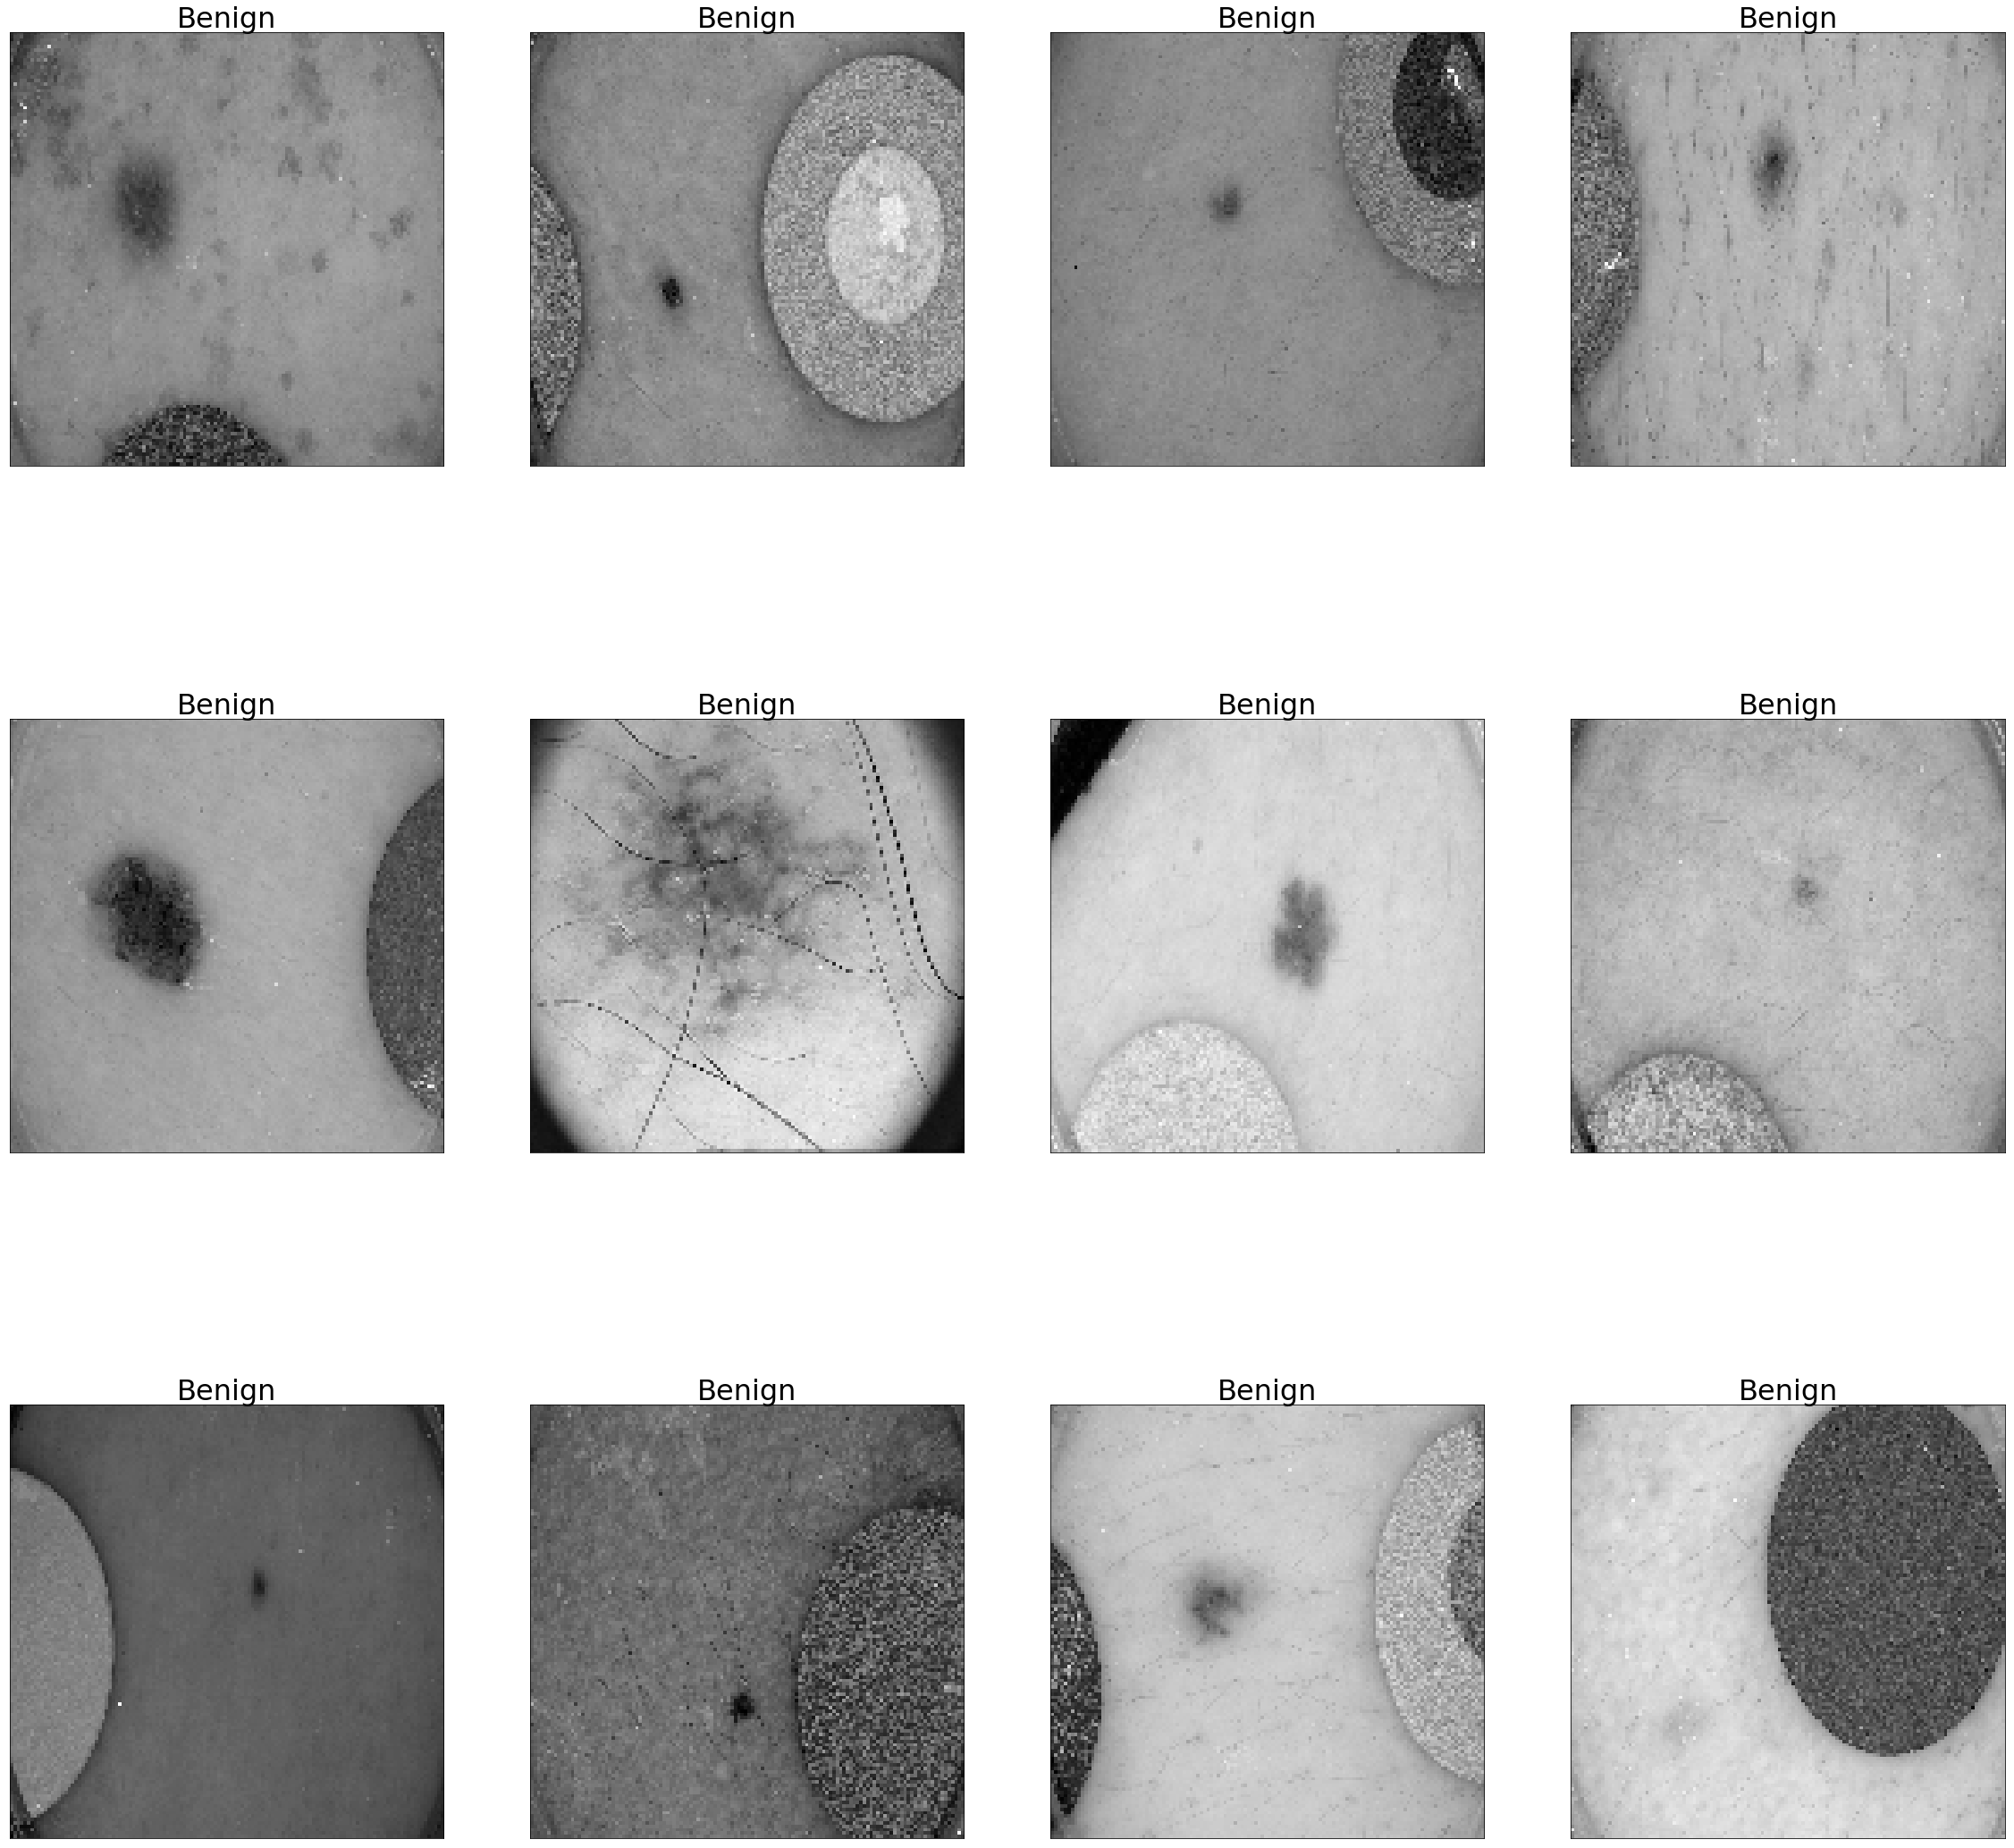

In [31]:
fig = plt.figure()

for num, data in enumerate(train_data_gray[-12:]):
    # malignant: [1,0]
    # benign: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Benign'
    else: str_label='Malignant'
        
    y.imshow(orig)
    plt.title(str_label, fontsize=32)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [207]:
## tensorboard --logdir=/Users/philipp/Projects/isic-archive-reader/classifier